In [1]:
import time
from dataclasses import dataclass
from dataclasses import field
from datetime import datetime

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
import os

print(os.getcwd())
os.chdir('../')
print(os.getcwd())

/Users/svetlanatelnova/university/portfolio_optimization/hse-course-work-bonds/notebook
/Users/svetlanatelnova/university/portfolio_optimization/hse-course-work-bonds


In [3]:
DAY_SECONDS = 60 * 60 * 24


def today() -> pd.Timestamp:
    """
    pd.Timestamp today midnight
    """
    seconds = time.time() - time.timezone
    seconds_round_day = seconds - (seconds % DAY_SECONDS)
    return pd.Timestamp.fromtimestamp(seconds_round_day + time.timezone)

Pick some bonds to use in the current optimization

In [4]:
BOND_UNIVERSE: tuple[str] = (
    "RU000A0GN9A7",
    "RU000A0JWDN6",
    "RU000A0JV4Q1",
#     "RU000A0JVA10",
    "RU000A0JW0S4",
    "RU000A0JUMH3",
    "RU000A0JV4N8",
#     "RU000A0D0G29",
#     "RU000A0JPLH5",
#    "RU000A0JQ8V9",
#     "RU000A0JQAL8",
#     "RU000A0JQAM6",
    "RU000A0JQRD9",
    "RU000A0JWUB5",
#     "RU000A0JWUX9",
    "RU000A0JWV89",
#     "RU000A0JWVL2",
#     "RU000A0JWVT5",
#     "RU000A0JWWM8",
#     "RU000A0JWX04",
#     "RU000A0JWYJ0",
#     "RU000A0JWYQ5",
#     "RU000A0JWZY6",

#     "RU000A101MG4"
)

In [29]:
from functools import cached_property


class BondDataProvider:
    """Data provider for bonds and"""

    def __init__(self):
        """Read all pre-downloaded data."""
        df_price = pd.read_csv("/Users/svetlanatelnova/university/portfolio_optimization/hse-course-work-bonds/data/bond_data_price.csv", parse_dates=["date"])
        df_price["date"] = df_price["date"].dt.date
        df_price = df_price.set_index(["date", "isin"])
        df_price = df_price.sort_index(level="date")
        all_dates=df_price.index.levels[0].unique()
        all_isins = df_price.index.levels[1].unique()
        new_index = pd.MultiIndex.from_product([all_dates, all_isins], names=['date', 'isin'])
        df_price_reindexed = df_price.reindex(new_index)
        self._price = df_price_reindexed.groupby(level='isin').fillna(method='ffill')
        
        df_dur = pd.read_csv("/Users/svetlanatelnova/university/portfolio_optimization/hse-course-work-bonds/data/bond_data_duration.csv", parse_dates=["date"])
        df_dur["date"] = df_dur["date"].dt.date
        self._dur = df_dur.set_index(["date", "isin"]).sort_index(level="date")
#         all_dates_dur = pd.date_range(start=df_dur.index.levels[0].min(), end=df_dur.index.levels[0].max())
#         # Get all unique 'isin' values
#         all_isins_dur = df_dur.index.levels[1].unique()
#         full_index = pd.MultiIndex.from_product([all_dates_dur, all_isins_dur], names=['date', 'isin'])

#         # Remove entries from full_index that are already in df's index
#         new_index = full_index.difference(df_dur.index)

#         # Reindex the DataFrame with the new index
#         df_dur_reindexed = df_dur.reindex(df_dur.index.union(new_index))

#         # Fill missing values
#         self._dur = df_dur_reindexed.groupby(level='isin').fillna(method='ffill')
        
        self._static = pd.read_csv("/Users/svetlanatelnova/university/portfolio_optimization/hse-course-work-bonds/data/bond_data_static.csv")
        self._rating = pd.read_csv(
            "/Users/svetlanatelnova/university/portfolio_optimization/hse-course-work-bonds/data/bond_data_rating.csv", parse_dates=["update_date"]
        )
        self._rating["update_date"] = self._rating["update_date"].dt.date
        self._rating["isin"] = self._rating["isincode"]

        self._volume = pd.read_csv("/Users/svetlanatelnova/university/portfolio_optimization/hse-course-work-bonds/data/bond_data_volume.csv")
        self._rgbitr = pd.read_csv("/Users/svetlanatelnova/university/portfolio_optimization/hse-course-work-bonds/data/bond_data_rgbitr.csv", parse_dates=["date"])

        self._yield = pd.read_csv("/Users/svetlanatelnova/university/portfolio_optimization/hse-course-work-bonds/data/bond_data_yield.csv", parse_dates=["date"])
        self._yield["date"] = pd.to_datetime(self._yield["date"].dt.date)
        self._yield = self._yield.sort_values("date")
        
    @property
    def price(self):
        """
        df with bond's historical prices
        columns: 'isin','date','spread','ask','bid','ai','last','mid'
        """
        return self._price

    @property
    def duration(self):
        """
        df with bond's precomputed duration data
        columns: 'id','date','isin','emission_id','emission_emitent_id','trading_ground_id','avar_price',
        'convexity','convexity_offer','dur','dur_to','dur_mod','dur_mod_to'
        """
        return self._dur

    @property
    def static(self):
        """Static bond info including coupon data."""
        return self._static

    @property
    def rating(self):
        """Bond ratings data."""
        return self._rating

    @property
    def volume(self):
        """Traded volume data.
        columns: 'volume' -- traded volume ,'volume_lots' -- number of traded lots
        """
        return self._volume

    @property
    def yield_(self):
        """Estimated bond yields."""
        return self._yield

    @cached_property
    def rgbitr(self):
        """RGBITR benchmark."""
        return self._rgbitr[self._rgbitr["secid"] == "RGBITR"]

    @cached_property
    def rucbitr(self):
        """RUCBITR benchmark.

        Note: halts after 05/31/2023
        """
        return self._rgbitr[self._rgbitr["secid"] == "RUCBITR"]

bond_data = BondDataProvider()


/var/folders/47/m1n0krg53lbb1g1klf717_mr0000gp/T/ipykernel_29051/1434593271.py:25: FutureWarning: DataFrameGroupBy.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self._price = df_price_reindexed.groupby(level='isin').fillna(method='ffill')
/var/folders/47/m1n0krg53lbb1g1klf717_mr0000gp/T/ipykernel_29051/1434593271.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self._price = df_price_reindexed.groupby(level='isin').fillna(method='ffill')


In [30]:
print(bond_data.price)
print(bond_data.duration)

                          spread      ask      bid       ai     last      mid
date       isin                                                              
2019-12-03 RU0002867854  0.00250  1.20250  1.20000  0.02685  1.19020  1.19020
           RU0002868001      NaN      NaN      NaN      NaN      NaN      NaN
           RU000A0D0G29  0.00144  1.01144  1.01000  0.00087  1.01000  1.01000
           RU000A0GN9A7  0.00075  1.00905  1.00830  0.02118  1.00905  1.00905
           RU000A0JPLH5  0.00109  0.99430  0.99321  0.02004  0.99340  0.99340
...                          ...      ...      ...      ...      ...      ...
2023-09-20 RU000A0JWYK8  0.00100  1.00100  1.00000  0.00000  1.00100  1.00100
           RU000A0JWYQ5  0.00200  0.99400  0.99200  0.02418  0.99950  0.99950
           RU000A0JWZT6  0.20000      NaN  0.98000  0.00000  1.04700  1.04700
           RU000A0JWZY6  0.00130  0.97700  0.97570  0.00638  0.97700  0.97700
           RU000A0JX009  0.00490  1.02490  1.02000  0.04634  1.0

In [31]:
@dataclass
class BondPortfolio:
    """portfolio history and basic statistics."""

    bond_universe: tuple[str] = field(default=tuple)
    cash: float = 1

    def __post_init__(self):
        self.universe_size: int = len(self.bond_universe)

        # current portfolio portions of bonds from the universe
        self._weights: np.array = np.zeros(self.universe_size)

        # current quantities of bonds from the universe
        self._qty: np.array = np.zeros(self.universe_size)

        self._history_weights: dict[pd.Timestamp, np.array] = {}
        self._history_qty: dict[pd.Timestamp, np.array] = {}

        # current date
        self._date: pd.Timestamp = today()

    def update_portfolio(
        self, weights: np.array, qty: np.array, cash: float, date: pd.Timestamp
    ):
        """Should be called when bonds quantity is changed"""
        self._date = date
        self.cash = cash

        self._weights = weights
        self._history_weights[date] = weights

        self._qty = qty
        self._history_qty[date] = qty

    @property
    def weights(self):
        """Weights for the current_date."""
        return self._weights

    def wealth(self, prices: np.array):
        """Total value af assets and money on account."""
        return self.cash + self._qty @ prices

In [32]:
# create portfolio for a simple strategy
port = BondPortfolio(
    bond_universe=BOND_UNIVERSE,
    cash=1,
)

## Random Weights Strategy

In [33]:
%%time
start_date, end_date = (
    pd.Timestamp("2023-08-01"),
    bond_data.price.index.get_level_values(0).max(),
)
day_ = pd.Timedelta(days=1)

dates = pd.date_range(start_date, end_date).date
for date in dates:
    print("======================================================")
    print(date)
    print(bond_data.price.index.get_level_values('date'))
    if not date in bond_data.price.index.get_level_values('date'):
        continue
    print(0)
    today_bond_data = bond_data.price.loc[(date, port.bond_universe),]
    if len(today_bond_data) < len(port.bond_universe):
        continue

    a = (np.random.uniform(-1, 1, port.universe_size) + 1) / 2

    price_today = bond_data.price.loc[
        pd.IndexSlice[slice(date, date), port.bond_universe], :
    ]
    
    if price_today.empty:
        continue
    price_today = price_today.loc[(slice(None), port.bond_universe),].mid
    new_weights = a / a.sum(axis=0, keepdims=1)
    wealth = port.wealth(price_today.values)
    print(f"{wealth = }")
    qty = wealth * new_weights / price_today
    print(new_weights)
    print(new_weights - port.weights)
    cash = wealth - qty @ price_today
    port.update_portfolio(new_weights, qty, cash, date)
    

2023-08-01
Index([2019-12-03, 2019-12-03, 2019-12-03, 2019-12-03, 2019-12-03, 2019-12-03,
       2019-12-03, 2019-12-03, 2019-12-03, 2019-12-03,
       ...
       2023-09-20, 2023-09-20, 2023-09-20, 2023-09-20, 2023-09-20, 2023-09-20,
       2023-09-20, 2023-09-20, 2023-09-20, 2023-09-20],
      dtype='object', name='date', length=382850)
0
wealth = 1.0
[0.18241165 0.0662237  0.0557684  0.09265315 0.05765013 0.2381323
 0.05164489 0.23325319 0.02226257]
[0.18241165 0.0662237  0.0557684  0.09265315 0.05765013 0.2381323
 0.05164489 0.23325319 0.02226257]
2023-08-02
Index([2019-12-03, 2019-12-03, 2019-12-03, 2019-12-03, 2019-12-03, 2019-12-03,
       2019-12-03, 2019-12-03, 2019-12-03, 2019-12-03,
       ...
       2023-09-20, 2023-09-20, 2023-09-20, 2023-09-20, 2023-09-20, 2023-09-20,
       2023-09-20, 2023-09-20, 2023-09-20, 2023-09-20],
      dtype='object', name='date', length=382850)
0
wealth = 0.9992949203854452
[0.16422733 0.0417599  0.11229164 0.10244027 0.15500446 0.0651565
 0.08

0
wealth = 0.9870909577473819
[0.14503947 0.09465094 0.03241484 0.13704716 0.21794883 0.03431876
 0.08288059 0.10054821 0.15515119]
[ 0.00093934  0.07644472 -0.23571939  0.13255418  0.18023196  0.01657012
 -0.05334767 -0.01285935 -0.10481392]
2023-08-18
Index([2019-12-03, 2019-12-03, 2019-12-03, 2019-12-03, 2019-12-03, 2019-12-03,
       2019-12-03, 2019-12-03, 2019-12-03, 2019-12-03,
       ...
       2023-09-20, 2023-09-20, 2023-09-20, 2023-09-20, 2023-09-20, 2023-09-20,
       2023-09-20, 2023-09-20, 2023-09-20, 2023-09-20],
      dtype='object', name='date', length=382850)
0
wealth = 1.0039609585124822
[0.24643782 0.0480725  0.05967291 0.18835859 0.05314126 0.06817995
 0.00071679 0.1080397  0.22738048]
[ 0.10139835 -0.04657844  0.02725808  0.05131143 -0.16480757  0.03386118
 -0.0821638   0.00749148  0.07222929]
2023-08-19
Index([2019-12-03, 2019-12-03, 2019-12-03, 2019-12-03, 2019-12-03, 2019-12-03,
       2019-12-03, 2019-12-03, 2019-12-03, 2019-12-03,
       ...
       2023-09-20

0
wealth = 0.9922292098667088
[0.19661943 0.02356217 0.21379583 0.07231865 0.21985544 0.22842784
 0.00712271 0.02973069 0.00856723]
[ 8.15536827e-02 -6.99617037e-02  9.45497582e-05  2.59614404e-02
  1.23493665e-01  1.46711824e-01 -9.75371792e-02  2.42021719e-02
 -2.34518451e-01]
2023-09-05
Index([2019-12-03, 2019-12-03, 2019-12-03, 2019-12-03, 2019-12-03, 2019-12-03,
       2019-12-03, 2019-12-03, 2019-12-03, 2019-12-03,
       ...
       2023-09-20, 2023-09-20, 2023-09-20, 2023-09-20, 2023-09-20, 2023-09-20,
       2023-09-20, 2023-09-20, 2023-09-20, 2023-09-20],
      dtype='object', name='date', length=382850)
0
wealth = 0.9927768451940319
[0.17011979 0.14940452 0.20816459 0.07156374 0.20083637 0.0223665
 0.03205522 0.11701092 0.02847836]
[-0.02649964  0.12584234 -0.00563125 -0.00075492 -0.01901907 -0.20606134
  0.0249325   0.08728024  0.01991113]
2023-09-06
Index([2019-12-03, 2019-12-03, 2019-12-03, 2019-12-03, 2019-12-03, 2019-12-03,
       2019-12-03, 2019-12-03, 2019-12-03, 2019

### Random Weights Strategy Results

In [34]:
wealth

0.9688784888245255

In [35]:
# df with "dur_mod", "yield", "shape" field for each day and each bond
sharpe_data = (
    bond_data.duration.groupby(["date", "isin"])
    .dur_mod.mean()
    .to_frame()
    .loc[(slice(None), BOND_UNIVERSE), ["dur_mod"]]
    .fillna(float("inf"))
    .join(
        bond_data.yield_.set_index(["date", "isin"]).loc[
            (slice(None), BOND_UNIVERSE), ["yield"]
        ],
    )
)

sharpe_data["sharpe"] = sharpe_data["yield"] / sharpe_data["dur_mod"]
sharpe_data = sharpe_data.sort_index()

In [36]:
sharpe_data_sorted = sharpe_data.loc[date].sort_values(
    "sharpe", ascending=False
)
sharpe_data_sorted["sharpe_squared"] = sharpe_data_sorted["sharpe"] ** 2
sharpe_data_sorted["weight"] = (
    sharpe_data_sorted["sharpe_squared"]
    / sharpe_data_sorted["sharpe_squared"].sum()
)
sharpe_data_sorted
# select max sharp
# weights = (
#     sharpe_data_sorted.loc[(slice(None), universe), :]

,dur_mod,yield,sharpe,sharpe_squared,weight
isin,,,,,
RU000A0JUMH3,0.588109,0.115846,0.196981,0.038802,0.650446
RU000A0JQRD9,1.132534,0.117461,0.103715,0.010757,0.180320
RU000A0JW0S4,1.855754,0.127511,0.068711,0.004721,0.079144
RU000A0JWDN6,2.274082,0.118546,0.052129,0.002717,0.045554
RU000A0JWV89,2.593502,0.095057,0.036652,0.001343,0.022519
RU000A0JWUB5,2.772511,0.070683,0.025494,0.000650,0.010895
RU000A0GN9A7,6.657464,0.115169,0.017299,0.000299,0.005017
RU000A0JV4N8,5.636553,0.081891,0.014529,0.000211,0.003538
RU000A0JV4Q1,6.702876,0.082937,0.012373,0.000153,0.002566


In [37]:
sharpe_data.loc[(date, slice(None)), :].sort_values(
        "sharpe", ascending=False
    )

dur_mod     yield    sharpe
date       isin                                      
2023-09-20 RU000A0JUMH3  0.588109  0.115846  0.196981
           RU000A0JQRD9  1.132534  0.117461  0.103715
           RU000A0JW0S4  1.855754  0.127511  0.068711
           RU000A0JWDN6  2.274082  0.118546  0.052129
           RU000A0JWV89  2.593502  0.095057  0.036652
           RU000A0JWUB5  2.772511  0.070683  0.025494
           RU000A0GN9A7  6.657464  0.115169  0.017299
           RU000A0JV4N8  5.636553  0.081891  0.014529
           RU000A0JV4Q1  6.702876  0.082937  0.012373

In [38]:
port = BondPortfolio(
    cash=1,
    bond_universe=BOND_UNIVERSE,
)

In [39]:
def get_weights(date: datetime.date, universe: tuple[str]):
    """Get target weights based on sharpe ratio."""
    sharpe_data_sorted = sharpe_data.loc[(date, slice(None)), :].sort_values(
        "sharpe", ascending=False
    )
    sharpe_data_sorted["sharpe_squared"] = sharpe_data_sorted["sharpe"] ** 2
    sharpe_data_sorted["weight"] = (
        sharpe_data_sorted["sharpe_squared"]
        / sharpe_data_sorted["sharpe_squared"].sum()
    )

    # select max sharp
    weights = (
        sharpe_data_sorted.loc[(slice(None), universe), :]
        .reset_index()["weight"]
        .fillna(0)
        .values
    )
    assert len(weights) == len(universe), f"{len(weights)},  {len(universe)}"
    return weights

In [40]:
%%time

start_date, end_date = (
    pd.Timestamp("2023-08-01"),
    bond_data.price.index.get_level_values(0).max(),
)
dates = pd.date_range(start_date, end_date).date
for date in dates:
    print("======================================================")
    print(date)

    if not date in bond_data.price.index.get_level_values('date'):
        continue

    today_bond_data = bond_data.price.loc[(date, port.bond_universe),]
    if len(today_bond_data) < len(port.bond_universe):
        continue

    
    price_today = bond_data.price.loc[slice(date, date), port.bond_universe, :]
    if price_today.empty:
        continue
    price_today = price_today.loc[(slice(None), port.bond_universe),].mid

    new_weights = get_weights(date, BOND_UNIVERSE)  # optimal sharp weights

    wealth = port.wealth(price_today.values)
    print(f"{wealth = }")
    qty = wealth * new_weights / price_today.values
    cash = wealth - qty @ price_today.values
    print(f"{cash = }")
    port.update_portfolio(new_weights, qty, cash, date)

2023-08-01
wealth = 1.0
cash = 1.1102230246251565e-16
2023-08-02
wealth = 1.0000344573973514
cash = 0.0
2023-08-03
wealth = 0.9986303937923655
cash = 0.0
2023-08-04
wealth = 0.9990225074061396
cash = 0.0
2023-08-05
2023-08-06
2023-08-07
wealth = 0.9976904270756243
cash = 1.1102230246251565e-16
2023-08-08
wealth = 0.9966846413990301
cash = -1.1102230246251565e-16
2023-08-09
wealth = 0.997425324198714
cash = -1.1102230246251565e-16
2023-08-10
wealth = 0.9997227156967613
cash = 1.1102230246251565e-16
2023-08-11
wealth = 0.9959498364227335
cash = 0.0
2023-08-12
2023-08-13
2023-08-14
wealth = 0.9958884005841677
cash = 0.0
2023-08-15
wealth = 0.9872067585575173
cash = -1.1102230246251565e-16
2023-08-16
wealth = 0.993894961418724
cash = 0.0
2023-08-17
wealth = 0.9899418702610897
cash = -1.1102230246251565e-16
2023-08-18
wealth = 0.9930697598060493
cash = 1.1102230246251565e-16
2023-08-19
2023-08-20
2023-08-21
wealth = 0.9966154947906978
cash = -2.220446049250313e-16
2023-08-22
wealth = 0.9933

### Sharpe Ratio Strategy Results

In [41]:
wealth

0.9819709920980243

## Quadratic optimization

In [43]:
# create portfolio for a quadratic optimization
port = BondPortfolio(
    bond_universe=BOND_UNIVERSE,
    cash=1,
)


In [60]:
%%time

from baseline.quadratic import get_optimal_weights

start_date, end_date = (
    pd.Timestamp("2023-07-01"),
    bond_data.price.index.get_level_values(0).max(),
)
dates = pd.date_range(start_date, end_date).date
for date in dates:
    print("======================================================")
    print(date)

    if not date in bond_data.price.index.get_level_values('date'):
        continue
    today_bond_data = bond_data.price.loc[(date, slice(None)),]
    if len(today_bond_data) < len(port.bond_universe):
        continue
    price_today = bond_data.price.loc[slice(date, date), port.bond_universe, :]

    if price_today.empty:
        continue  
    if len(price_today) < len(port.bond_universe):
        continue
    price_today = price_today.loc[(slice(None), port.bond_universe),].mid
    if len(today_bond_data) < len(port.bond_universe):
        continue
    #
    # prepare data
    #
    grouped=bond_data.yield_.set_index(["date", "isin"])
    if not date in grouped.index.get_level_values('date').date:
        continue
    today_info = (
        price_today.to_frame()
        .join(
            bond_data.duration.loc[
                pd.IndexSlice[slice(date, date), port.bond_universe], "dur_mod"
            ]
            .groupby(["date", "isin"])
            .mean()
            .fillna(float("inf"))
        )
        .join(
            bond_data.yield_.set_index(["date", "isin"]).loc[
                (slice(date, date), port.bond_universe), :
            ]
        )
    )
    rating_reduced = bond_data.rating[
        bond_data.rating["isin"].isin(port.bond_universe)
        & (bond_data.rating.update_date < date)
    ].sort_values("update_date")
    rating_reduced = rating_reduced.groupby("isin").num_rating.last()
    today_info = today_info.join(rating_reduced)
    today_info["num_rating"] = today_info["num_rating"].fillna(0)

    new_weights = get_optimal_weights(
        bond_data=today_info,
        upper_bound=0.5,
        value_date=date,
        maturity_limit=10,
    )  # optimal sharp weights

    wealth = port.wealth(price_today.values)
    print(f"{wealth = }")
    qty = wealth * new_weights / price_today.values
    cash = wealth - qty @ price_today.values
    print(f"{cash = }")
    port.update_portfolio(new_weights, qty, cash, date)

2023-07-01
2023-07-02
2023-07-03
wealth = 1.0691104442278931
cash = -9.392486788328824e-13
2023-07-04
wealth = 1.0675358546947225
cash = -8.344436253082677e-13
2023-07-05
wealth = 1.0709020288525584
cash = -1.5982770662503754e-12
2023-07-06
wealth = 1.0714998730627552
cash = -7.016298653184094e-11
2023-07-07
wealth = 1.0720428886322273
cash = -1.0835776720341528e-12
2023-07-08
2023-07-09
2023-07-10
wealth = 1.071934261325643
cash = -6.110667527536862e-13
2023-07-11
wealth = 1.0706306015368603
cash = -1.4934720127257606e-12
2023-07-12
wealth = 1.0719358506700842
cash = -7.973621762857874e-13
2023-07-13
wealth = 1.070740827425189
cash = -2.2182256032010628e-12
2023-07-14
wealth = 1.0694900890284993
cash = -1.765476653758924e-12
2023-07-15
2023-07-16
2023-07-17
wealth = 1.068836765821993
cash = -2.2857271630982723e-12
2023-07-18
wealth = 1.070471072803372
cash = -8.216316516040933e-12
2023-07-19
wealth = 1.0710694052119643
cash = -1.709743457922741e-13
2023-07-20
wealth = 1.07155867658780

wealth = 1.0430345456177461
cash = -1.9881873924987303e-12
2023-09-16
2023-09-17
2023-09-18
wealth = 1.0431515248283296
cash = -1.8327561690512084e-12
2023-09-19
wealth = 1.0439606712174094
cash = -5.708766792622555e-13
2023-09-20
wealth = 1.0442212912225504
cash = -8.881784197001252e-16
CPU times: user 29.6 s, sys: 5.03 s, total: 34.7 s
Wall time: 35.4 s


In [61]:
wealth

1.0442212912225504

# Linear programming

In [52]:
from models.linear_programming import linear_minimize

In [53]:
# create portfolio for a linear programming optimization
port = BondPortfolio(
    bond_universe=BOND_UNIVERSE,
    cash=1,
)

In [55]:
%%time

start_date, end_date = (
    pd.Timestamp("2023-03-01"),
    bond_data.price.index.get_level_values(0).max(),
)
dates = pd.date_range(start_date, end_date).date
for date in dates:
    print("======================================================")
    print(date)

    if not date in bond_data.price.index.get_level_values('date'):
        continue

    today_bond_data = bond_data.price.loc[(date, slice(None)),]
    if len(today_bond_data) < len(port.bond_universe):
        continue
        
    price_today = bond_data.price.loc[slice(date, date), port.bond_universe, :]
    if price_today is None or price_today.empty:
        continue    
    if len(price_today) <8:
        print("We have this conflict")
    if len(price_today) < len(port.bond_universe):
        continue
    grouped_yield=bond_data.yield_.set_index(["date", "isin"])
    if not date in grouped_yield.index.get_level_values('date').date:
        continue   
    price_today = price_today.loc[(slice(None), port.bond_universe),].mid
    today_info = (
        price_today.to_frame()
        .join(
            bond_data.duration.loc[
                pd.IndexSlice[slice(date, date), port.bond_universe], "dur_mod"
            ]
            .groupby(["date", "isin"])
            .mean()
            .fillna(float("inf"))
        )
        .join(
            grouped_yield.loc[
                (slice(date, date), port.bond_universe), :
            ]
        )
    )

    rating_reduced = bond_data.rating[
        bond_data.rating["isin"].isin(port.bond_universe)
        & (bond_data.rating.update_date < date)
    ].sort_values("update_date")

    rating_reduced = rating_reduced.groupby("isin").num_rating.last()
    today_info = today_info.join(rating_reduced)
    
    today_info["num_rating"] = today_info["num_rating"].fillna(0)
    rating_reduced = today_info["num_rating"]

    new_weights=linear_minimize(today_info, weight_at_least=0.1)
    
    if new_weights is None:
        print("No answer for you")
        
    print(new_weights)

    wealth = port.wealth(price_today.values)
    print(f"{wealth = }")
    qty = wealth * new_weights / price_today.values
    cash = wealth - qty @ price_today.values
    print(f"{cash = }")
    port.update_portfolio(new_weights, qty, cash, date)

2023-03-01
[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 1.014286217713465
cash = -2.220446049250313e-16
2023-03-02
[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 1.013172914494779
cash = -2.220446049250313e-16
2023-03-03
[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 1.0583184321428647
cash = -2.220446049250313e-16
2023-03-04
2023-03-05
2023-03-06
[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.2 0.1]
wealth = 1.0626949734005775
cash = -2.220446049250313e-16
2023-03-07
[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 1.0635739345489934
cash = -2.220446049250313e-16
2023-03-08
2023-03-09
[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 1.063742553866501
cash = -2.220446049250313e-16
2023-03-10
[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 1.0629539442391147
cash = -2.220446049250313e-16
2023-03-11
2023-03-12
2023-03-13
[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 1.062386437031206
cash = -2.220446049250313e-16
2023-03-14
[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 1.0584935811469833
cash = -2.220446

[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 1.04135386613398
cash = -2.220446049250313e-16
2023-05-04
[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 1.0419782623254783
cash = -2.220446049250313e-16
2023-05-05
[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 1.0420978920106936
cash = -2.220446049250313e-16
2023-05-06
2023-05-07
2023-05-08
[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 1.0466360968698774
cash = -2.220446049250313e-16
2023-05-09
2023-05-10
[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 1.0438000996250705
cash = -2.220446049250313e-16
2023-05-11
[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 1.0424817201482177
cash = -2.220446049250313e-16
2023-05-12
[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 1.0418200715992663
cash = -2.220446049250313e-16
2023-05-13
2023-05-14
2023-05-15
[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 1.0435734902321185
cash = -2.220446049250313e-16
2023-05-16
[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 1.044070202316131
cash = -2.220446049250313e

[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 1.0620407493671546
cash = -2.220446049250313e-16
2023-07-06
[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 1.05728545914746
cash = -2.220446049250313e-16
2023-07-07
[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 1.0638104713720031
cash = -2.220446049250313e-16
2023-07-08
2023-07-09
2023-07-10
[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 1.0604839706138194
cash = -2.220446049250313e-16
2023-07-11
[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 1.0628634844524638
cash = -2.220446049250313e-16
2023-07-12
[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 1.0624099099608124
cash = -2.220446049250313e-16
2023-07-13
[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 1.0610778464049477
cash = -2.220446049250313e-16
2023-07-14
[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 1.0631492922285362
cash = -2.220446049250313e-16
2023-07-15
2023-07-16
2023-07-17
[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 1.0541375186817776
cash = -2.220446049250313e-16
2023-0

[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 1.0456198863041373
cash = -2.220446049250313e-16
2023-09-06
[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 1.043528743885244
cash = -2.220446049250313e-16
2023-09-07
[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 1.0395381333213887
cash = -2.220446049250313e-16
2023-09-08
[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 1.0336391203242599
cash = -2.220446049250313e-16
2023-09-09
2023-09-10
2023-09-11
[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 1.0357549758996394
cash = -2.220446049250313e-16
2023-09-12
[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 1.0379574685448427
cash = -2.220446049250313e-16
2023-09-13
[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 1.0298732174928806
cash = -2.220446049250313e-16
2023-09-14
[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 1.0229255448743109
cash = -2.220446049250313e-16
2023-09-15
[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 1.0275202535676815
cash = -2.220446049250313e-16
2023-09-16
2023-09-17
2023-

In [56]:
wealth

1.0278604772179183

In [57]:
def get_portfolio_value_history(portfolio: BondPortfolio):
    """
    df with 'qty', 'spread', 'ask', 'bid', 'ai', 'last', 'mid' columns for each bond and trading day of the `portfolio`
    """
    portfolio_df = pd.DataFrame.from_dict(
        portfolio._history_qty, orient="index", columns=portfolio.bond_universe
    )
    portfolio_df.index.name = "date"

    # wide df -> long df
    portfolio_df = pd.melt(
        portfolio_df.reset_index(),
        "date",
        value_vars=portfolio.bond_universe,
        var_name="isin",
        value_name="qty",
    ).set_index(["date", "isin"])

    price_df = bond_data.price.reset_index()
    price_df = price_df.set_index(["date", "isin"])

    portfolio_history = pd.merge(
        portfolio_df,
        price_df,
        how="left",
        left_index=True,
        right_index=True,
    )

    return portfolio_history

#### portfolio PNL

In [58]:
portfolio_summary = get_portfolio_value_history(port)
portfolio_summary["value"] = portfolio_summary["qty"] * portfolio_summary["mid"]
portfolio_summary_grouped = portfolio_summary.groupby("date")

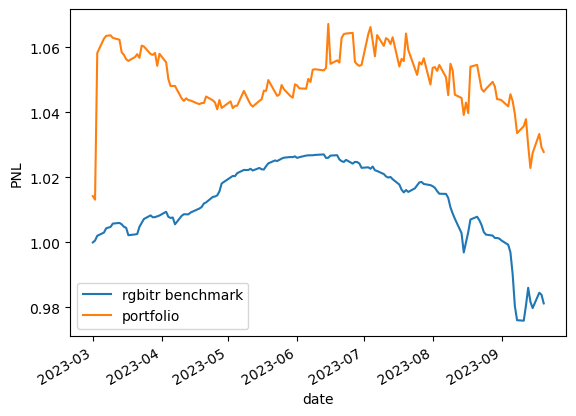

In [59]:
# benchmark rgbitr
rgbitr_slice = bond_data.rgbitr.set_index("date").loc[start_date:end_date]
pnl_benchmark = np.cumprod(rgbitr_slice.close.pct_change().fillna(0) + 1)
pnl_benchmark.index = pd.DatetimeIndex(pnl_benchmark.index)
pnl_benchmark.plot(label="rgbitr benchmark")

# portfolio
pnl_portfolio = portfolio_summary_grouped.value.sum()
pnl_portfolio.index = pd.DatetimeIndex(pnl_portfolio.index)
pnl_portfolio.plot(label="portfolio")
plt.legend()
plt.ylabel("PNL");

### mean and median return

In [ ]:
returns = portfolio_summary_grouped.value.sum().pct_change()
f"Mean return = {returns.mean():.3f}, Median return = {returns.median():.3f}"

## Sharpe Ratio

In [ ]:
rgbitr_slice = bond_data.rgbitr.set_index("date").loc[start_date:end_date]

returns_benchmark = rgbitr_slice.close.pct_change().iloc[1:]
returns_port = portfolio_summary_grouped.value.sum().pct_change().iloc[1:]

In [ ]:
def get_sharp_ratio(returns, returns_market):
    """
    Notes: https://www.investopedia.com/terms/s/sharperatio.asp
    """
    delta = returns.product() - returns_market.product()
    return delta / (returns - returns_market).std()


get_sharp_ratio(returns=returns_benchmark, returns_market=returns_port)

### Information Ratio

In [ ]:
def get_information_ratio(returns, returns_market):
    """
    Notes: https://www.investopedia.com/terms/i/informationratio.asp
    """
    difference_benchmark_portfolio = returns - returns_market
    tracking_error = difference_benchmark_portfolio.std()
    information_ratio = (returns.mean() - returns_market.mean()) / tracking_error
    return information_ratio

In [ ]:
information_ratio = get_information_ratio(
    returns=returns_benchmark, returns_market=returns_port
)
information_ratio

## Returns

In [ ]:
plt.figure()
sns.distplot(returns_benchmark, bins=42, label="benchmark returns")
sns.distplot(returns_port, bins=42, label="portfolio returns")
plt.legend();

# Returns difference

In [ ]:
returns_diff = returns_port - returns_benchmark
sns.distplot(returns_diff, bins=42, label="portfolio returns");

In [ ]:
from scipy import stats

stats.ttest_1samp(returns_diff, popmean=0)

# Benchmark Timing

One financially based refinement to the regression model is a benchmark timing component. The expanded model is

$$r_{P}(t) = \alpha_{P}+\beta_{P} * r_{B}(t) + \gamma_{P} * max(0, r_{B}(t)) + \epsilon_{P}(t)$$

We include the variable γP to determine whether the manager has any benchmark timing skill. The model includes a "down-market" beta, βP, and an "up-market" beta, βP + γP. If γP is significantly positive, then we say that there is evidence of timing skill; benchmark exposure is significantly different in up and down cases.


In [ ]:
import statsmodels.api as sm
import numpy as np

timing_df = returns_benchmark.to_frame().rename(columns={'close':'beta'})
timing_df['gamma'] = timing_df['beta']
timing_df.loc[timing_df['beta'] < 0, 'gamma'] = 0

X = sm.add_constant(timing_df)
benchmark_timing_model = sm.OLS(returns_port,X)
results = benchmark_timing_model.fit()
results.params

## Value at Risk

In [ ]:
alpha = 0.05
returns_benchmark.quantile(alpha)

## Skewness of Returns

In [ ]:
alpha = 0.05
returns_benchmark.skew()